In [239]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import tensorflow as tf
import zipfile
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from kerastuner import HyperModel, RandomSearch
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, SpatialDropout1D, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from wordcloud import WordCloud
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [240]:
# URL for the GloVe embeddings
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"

In [241]:
# Download the zip file
glove_zip = "glove.6B.zip"
if not os.path.exists(glove_zip):
    print("Downloading GloVe embeddings...")
    with requests.get(glove_url, stream=True) as r:
        with open(glove_zip, 'wb') as f:
            f.write(r.content)
    print("Download complete.")

In [242]:
# Unzip the file
with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
    zip_ref.extractall("glove")
    print("Extraction complete.")

Extraction complete.


In [243]:
# Check the extracted files
os.listdir("glove")

['glove.6B.100d.txt',
 'glove.6B.300d.txt',
 'glove.6B.50d.txt',
 'glove.6B.200d.txt']

In [244]:
# Define the path to the GloVe file
glove_file_path = "glove/glove.6B.100d.txt"

In [245]:
# 1. Load and Explore the Dataset
df = pd.read_csv('/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')  

In [246]:
# Basic Data Inspection
print(df.head())
print('\n')
print(df.info())

                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB
None


# EDA

In [247]:
# Rating distribution
rating_counts = df['Rating'].value_counts()
print(rating_counts)

Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64


In [248]:
# Calculate the percentage distribution of ratings
rating_percentage = (rating_counts / rating_counts.sum()) * 100
print(rating_percentage)

Rating
5    44.185252
4    29.471475
3    10.658338
2     8.750183
1     6.934752
Name: count, dtype: float64


In [249]:
# Calculate review lengths in terms of word count
df['review_length'] = df['Review'].apply(lambda x: len(x.split()))

# Basic statistics on review length
print(df['review_length'].describe())

count    20491.000000
mean       104.375824
std        100.656586
min          7.000000
25%         48.000000
50%         77.000000
75%        124.000000
max       1931.000000
Name: review_length, dtype: float64


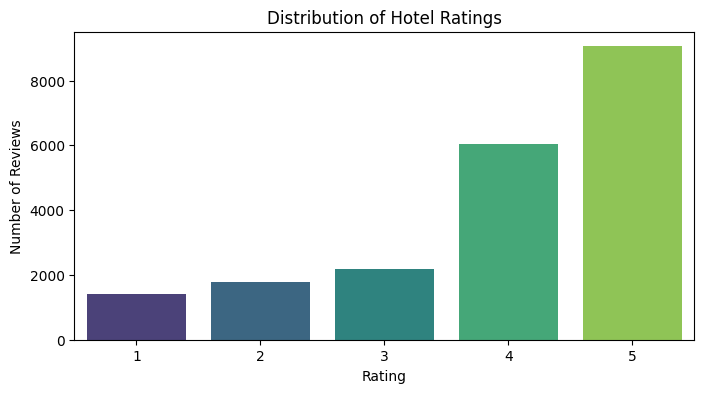

In [250]:
# Plot the distribution of ratings
plt.figure(figsize=(8, 4))
sns.countplot(x='Rating', data=df, palette='viridis')
plt.title('Distribution of Hotel Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


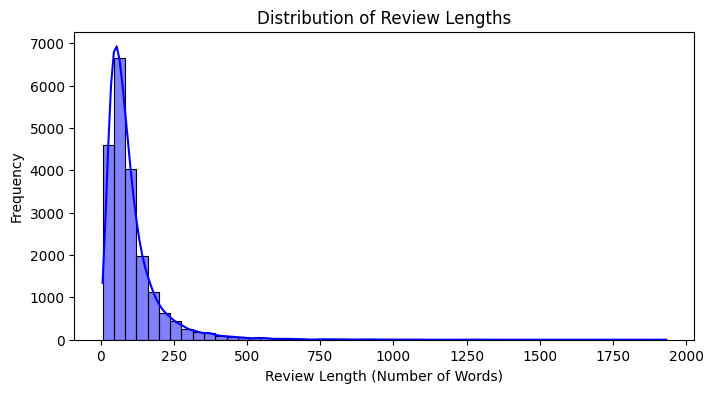

In [251]:
# Plot the distribution of review lengths
plt.figure(figsize=(8, 4))
sns.histplot(df['review_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

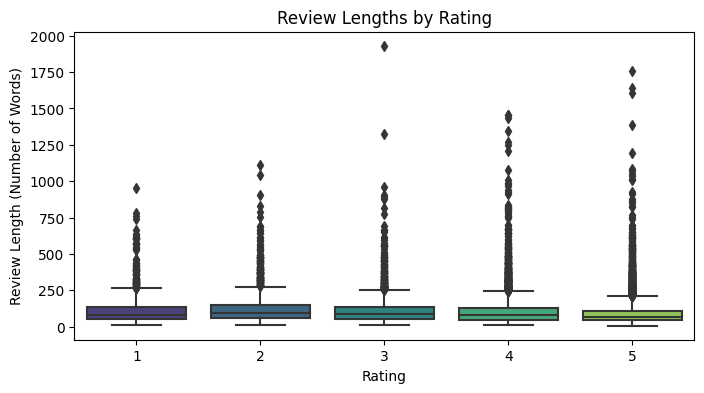

In [252]:
# Box plot of review lengths by rating
plt.figure(figsize=(8, 4))
sns.boxplot(x='Rating', y='review_length', data=df, palette='viridis')
plt.title('Review Lengths by Rating')
plt.xlabel('Rating')
plt.ylabel('Review Length (Number of Words)')
plt.show()

In [253]:
# Generate a word cloud for all reviews
text = ' '.join(df['Review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)


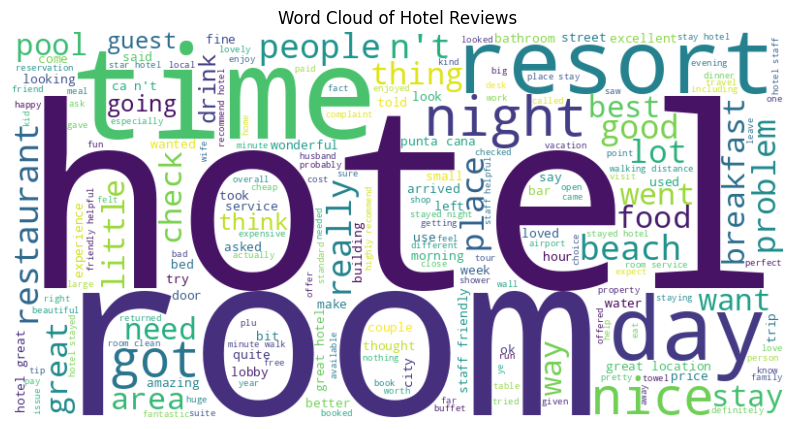

In [254]:
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Hotel Reviews')
plt.show()

# Text processsing

In [255]:
# Load GloVe embeddings
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [256]:
# Load GloVe embeddings
glove_embeddings = load_glove_embeddings(glove_file_path)

In [257]:
# Preprocess reviews
def clean_review(text):
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    text = text.split()
    stop_words = set(stopwords.words("english"))
    text = [word for word in text if word not in stop_words]
    return " ".join(text)

In [258]:
df['cleaned_review'] = df['Review'].apply(clean_review)
reviews = df['cleaned_review'].values
ratings = df['Rating'].values

In [259]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
word_index = tokenizer.word_index
max_seq_length = 100  # You can adjust this length

X = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')

In [260]:
# Convert ratings to categorical (one-hot encoding)
num_classes = 5  
encoder = LabelEncoder()
ratings_encoded = encoder.fit_transform(ratings)  # Transform to 0,1,2,3,4
ratings_one_hot = to_categorical(ratings_encoded, num_classes=num_classes)

In [261]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, ratings_one_hot, test_size=0.2, random_state=42)

In [262]:
# Create embedding matrix for our vocabulary
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [263]:
# Define the neural network model
model = Sequential([
    Embedding(input_dim=len(word_index) + 1,
                              output_dim=embedding_dim,
                              weights=[embedding_matrix],
                              input_length=max_seq_length,
                              trainable=True),  # Set trainable=False to freeze GloVe embeddings
    #SpatialDropout1D(0.3),
    Bidirectional(LSTM(192, return_sequences=False)),
    Dense(192, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Categorical classification for 5 classes
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [264]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [265]:
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001, verbose=1)

In [266]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [267]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_schedule], verbose=1)

Epoch 1/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 124s 233ms/step - accuracy: 0.5137 - loss: 1.8141 - val_accuracy: 0.6082 - val_loss: 0.9144 - learning_rate: 0.0010
Epoch 2/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 141s 232ms/step - accuracy: 0.6314 - loss: 0.8705 - val_accuracy: 0.6526 - val_loss: 0.8573 - learning_rate: 0.0010
Epoch 3/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 127s 248ms/step - accuracy: 0.6691 - loss: 0.7808 - val_accuracy: 0.6580 - val_loss: 0.8578 - learning_rate: 0.0010
Epoch 4/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7074 - loss: 0.7190
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
513/513 ━━━━━━━━━━━━━━━━━━━━ 121s 235ms/step - accuracy: 0.7074 - loss: 0.7190 - val_accuracy: 0.6421 - val_loss: 0.8659 - learning_rate: 0.0010
Epoch 5/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 121s 235ms/step - accuracy: 0.7429 - loss: 0.6352 - val_accuracy: 0.6538 - val_loss: 0.8541 - learning_rate: 5.0000e-04
Epoch 6/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 121s 236ms/step - accur

In [268]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')

129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.6599 - loss: 0.8408
Accuracy: 65.38%


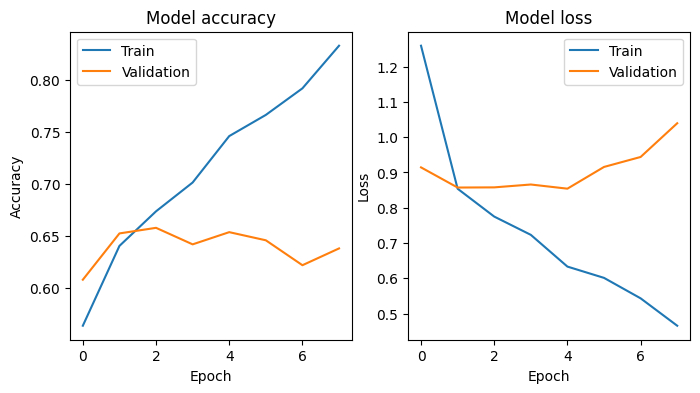

In [272]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

In [270]:
# Making predictions on the test data
predictions = model.predict(X_test)
predictions = np.round(predictions).astype(int)

129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step


In [271]:
# Show some predictions
for i in range(5):
    print(f"Tweet: {df['Review'].iloc[i]}")
    print(f"Actual Label: {df['Rating'].iloc[i]}, Predicted Label: {predictions[i]}")

Tweet: nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  
Actual Label: 4, Predicted Label: [1 0 0 0 0]
Tweet: ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got k